# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression
from sklearn.tree import ExtraTreeRegressor
import math as m
import seaborn as sns
from scipy import stats

In [18]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)
y = y.drop(columns=['id'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print(X_train.info())
X_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 806 to 1126
Columns: 828 entries, x0 to x831
dtypes: float64(828)
memory usage: 6.1 MB
None


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
678,16258.147290,10993.47063,3619.523793,97457.699707,105.844500,NaN,8962.844782,10347.586459,10627.068116,10.412674,...,10533.969843,13721.009286,677.095015,108.806077,104.056239,2490.067180,2.629971,1217.961889,1004.983401,9152.243458
1024,16158.417707,10893.57040,4329.600737,89493.733962,109.839409,108.901389,11432.648509,10801.817046,10194.445939,9.928844,...,9190.774085,14401.076185,753.056995,105.302858,104.232882,2521.090565,2.554467,1601.631558,1040.617328,10739.168762
387,14358.545993,9181.34063,3280.536540,111522.043413,107.578436,91.831856,9584.858482,10149.064427,10437.775288,11.447547,...,9838.914811,13531.096299,908.001163,103.862894,104.596962,2164.012227,2.952888,948.253018,1090.155759,12185.729154


### Handling outliers

In [99]:
def detection(df,features):
    outlier_indices=[]
    
    for c in features:
        Q1, Q3 = np.percentile(df[c],25), np.percentile(df[c],75)
        
        #IQR calculation
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        lower_range = Q1 - (outlier_step)
        upper_range = Q3 + (outlier_step)
        
        #Outlier detection                                    #Outlier indexes
        outlier_list_col=df[  (df[c] < lower_range) | (df[c] > upper_range)  ].index
        
        #Store indexes
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices=Counter(outlier_indices)
    # number of outliers
    # If we have more then 2 outliers in a sample, this sample ll be drop
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2 )
    #we are taking indexes
    
    return multiple_outliers

In [100]:
outliers = detection(X_train, X_train.columns)
X_train=X_train.drop(outliers,axis=0).reset_index(drop = True)
X_train.shape

(969, 828)

### Handling missing values 

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [20]:
y_test = y_test.fillna(y_test.median())
y_train = y_train.fillna(y_train.median())
X_test = X_test.fillna(X_test.median())

X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())


In [21]:
X_train_norm = X_train_filled.copy()
for col in X_train_filled.columns:
    X_train_norm[col] = (X_train_filled[col] - X_train_filled[col].mean()) / m.sqrt(X_train_filled[col].var())
X_train_norm

X_test_norm = X_test_filled.copy()
for col in X_test_filled.columns:
    X_test_norm[col] = (X_test_filled[col] - X_test_filled[col].mean()) / m.sqrt(X_test_filled[col].var())
X_test_norm

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
801,1.359533,0.459014,0.339587,-0.194593,0.783548,1.033031,-0.054079,1.386708,1.419838,0.316343,...,-0.934455,0.730277,-0.743350,-0.342046,0.945600,2.282991,-0.528466,-0.454877,1.485537,0.002413
677,-0.148333,-0.131357,0.665774,-1.069432,1.133581,1.811608,0.950913,-0.900671,0.422283,1.354028,...,0.814070,0.308782,-1.341874,-0.674404,-1.406581,0.312330,-0.009769,-0.046611,-1.079061,0.862273
43,-0.273613,1.601598,-0.809951,-0.010533,1.514877,-0.005275,0.570904,-1.385937,-0.046404,1.062219,...,-0.981165,-1.688710,-0.667807,-0.614756,1.109218,-1.782454,-1.193961,-0.025684,1.427604,-0.876229
990,-0.460091,-0.217644,1.313331,-0.918573,-1.276381,-0.005275,1.370343,-0.108825,-1.728645,1.053114,...,-0.613586,-0.933824,-0.006646,-1.377137,-0.105661,-0.598885,-0.130783,-0.327974,-0.211967,0.720824
70,1.030626,0.945782,1.528852,-0.120766,0.578191,-0.378145,-1.452431,-1.100144,1.654622,1.029604,...,-0.005430,1.462694,0.068921,0.723125,0.204150,0.737810,-0.130783,1.392817,1.441607,-1.205046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,0.580896,-0.131357,0.217757,1.232651,-0.875616,-1.445223,0.171942,-0.095679,0.781302,-0.980250,...,-0.327102,-0.357407,0.427206,0.614293,-0.341914,-0.010265,1.006951,0.285387,1.646663,-0.164958
673,-0.148333,0.154172,-1.454732,-1.482054,-0.343430,-0.449199,1.558752,1.457223,1.489332,0.686624,...,0.631523,0.309821,1.032625,-1.221606,0.337297,-0.754033,0.459332,0.915614,1.020814,0.323661
708,0.715143,-0.272410,2.109801,0.196859,-0.051390,-1.229249,-1.003329,0.018998,-0.046404,0.699176,...,-0.545884,0.109474,1.411440,0.470524,-1.182927,-1.381369,-1.632139,1.810377,0.674904,0.122216
367,-0.320823,-0.680830,0.435163,-0.558359,0.288287,0.266746,1.361249,-1.190624,-1.112909,-0.061817,...,1.782686,0.552893,-0.357741,-0.618208,0.101780,0.015179,-0.130783,0.410358,-0.005904,-0.925360


In [91]:
d = {}
for col in X_norm.columns:
    Q1, Q3 = np.percentile(X_norm[col],25), np.percentile(X_norm[col],75)
    IQR = Q3 - Q1
    outlier_step = IQR * 2
    lower_range = Q1 - (outlier_step)
    upper_range = Q3 + (outlier_step)
    d[col] = (lower_range, upper_range)
for i, row in X_norm.iterrows():
    for col in X_norm.columns:
        if row[col] < d[col][0] or row[col] > d[col][1]:
            X_norm.loc[i,col]=0
X_norm

NameError: name 'X_norm' is not defined

### Handling feature selections



In [36]:

select_feature = SelectKBest(f_regression, k=(5)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
X_train_new.shape


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(969, 10)

<AxesSubplot:>

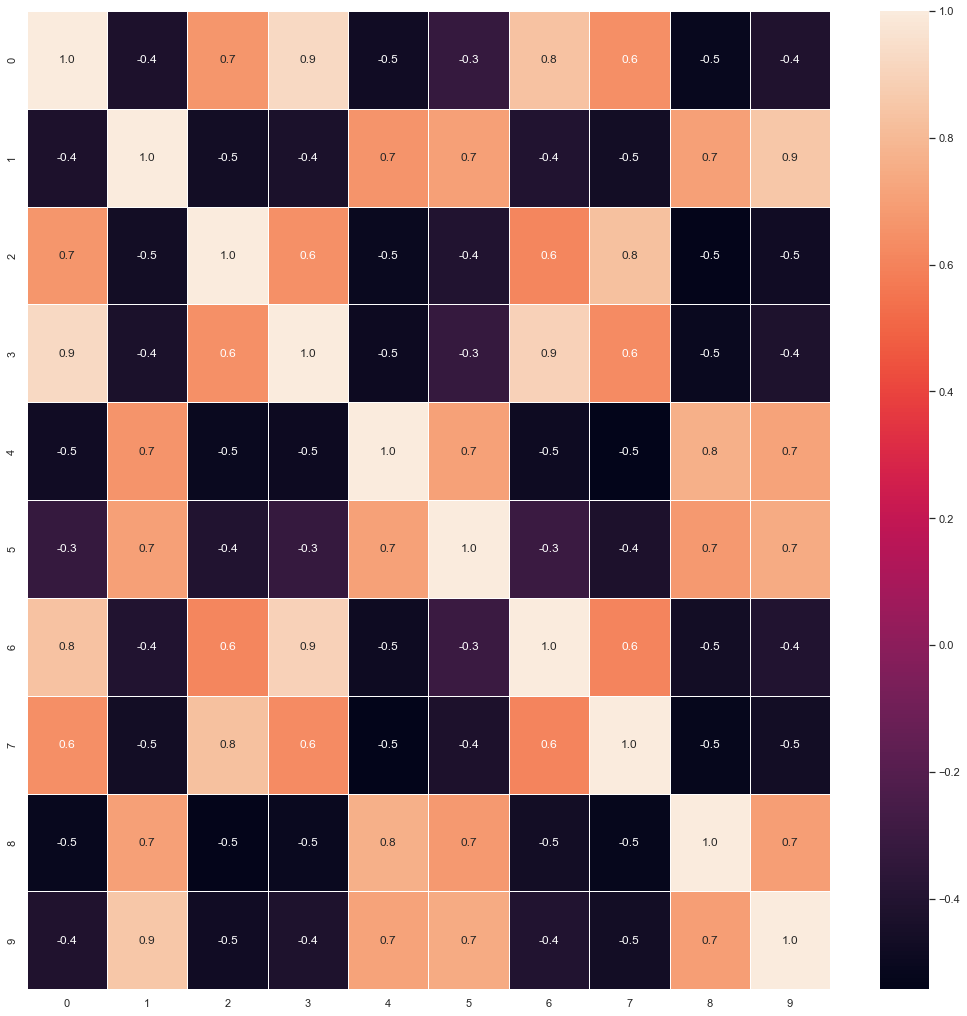

In [37]:
### Feature selecction visualization
# correlation map
X_dtf = pd.DataFrame(X_train_new)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X_dtf.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


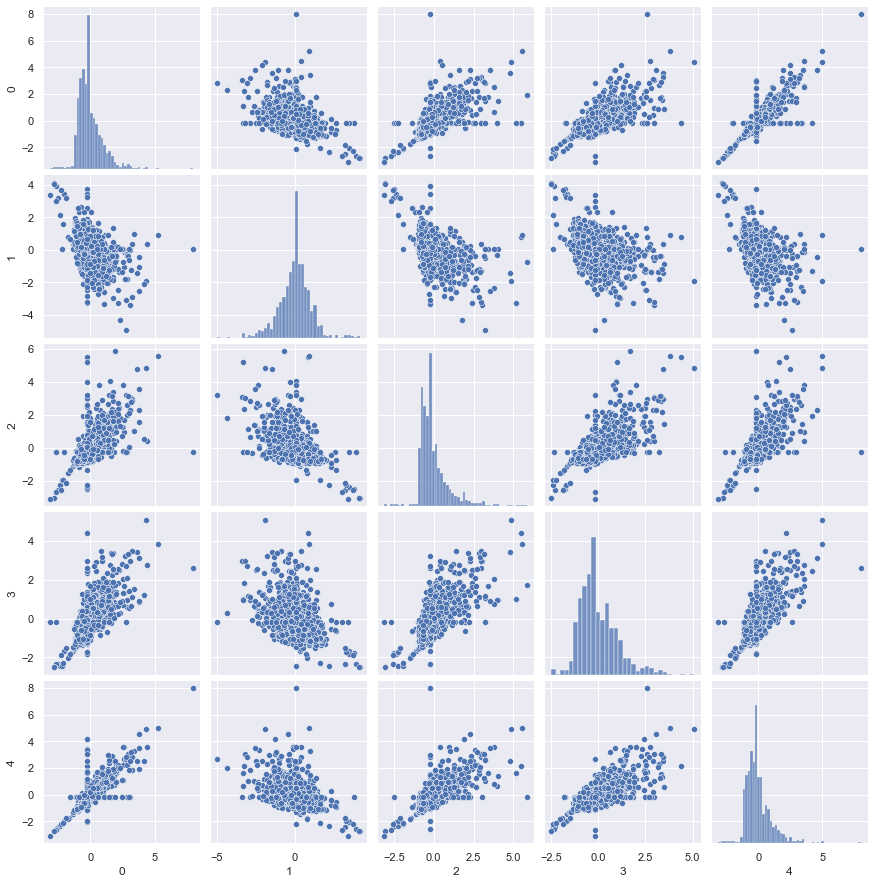

In [35]:
sns.set()
sns.pairplot(X_dtf, size = 2.5)
plt.show();

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 969 and the array at index 1 has size 10

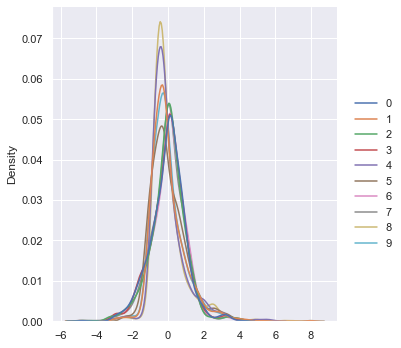

<Figure size 432x288 with 0 Axes>

In [43]:
sns.displot(X_dtf, kind="kde");
fig = plt.figure()
res = stats.probplot(X_dtf, plot=plt)

In [121]:
pca = PCA(n_components=68)
pca.fit(X_train_norm,y_train)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [14]:
model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.3560815428355485